# IsolationForest

In [1]:
import sqlite3
import yaml
import pandas as pd
from sklearn.ensemble import IsolationForest

In [17]:
with open('.\configurations.yml') as file:
    configurations = yaml.load(file, Loader=yaml.FullLoader)

db = sqlite3.connect(configurations["Database"]["Path"]) # connecting to sqlite database

df = pd.read_sql_query('''SELECT 
  id,
  valorTransacao,
  dataTransacao,
  codigoSubclasse,
  tipoCodigo,
  ROW_NUMBER() OVER(PARTITION BY valorTransacao, nome_portador ORDER BY dataTransacao ASC) 								AS valorTransacao_count_byPerson,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, nome_portador ORDER BY dataTransacao ASC) 			AS codigoFormatado_estabelecimento_count_byPerson,
  ROW_NUMBER() OVER(PARTITION BY valorTransacao, codigo_unidadeGestora ORDER BY dataTransacao ASC) 						AS valorTransacao_count_byAgency,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, codigo_unidadeGestora ORDER BY dataTransacao ASC) 	AS codigoFormatado_estabelecimento_count_byAgency,
  ROW_NUMBER() OVER(PARTITION BY valorTransacao, nome_orgaoMaximo ORDER BY dataTransacao ASC) 							AS valorTransacao_count_byDepartment,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, nome_orgaoMaximo ORDER BY dataTransacao ASC) 			AS codigoFormatado_estabelecimento_count_bydepartment  
FROM cartoes 
WHERE valorTransacao||nome_estabelecimento||nome_portador not in (SELECT -valorTransacao||nome_estabelecimento||nome_portador from cartoes where valorTransacao <0)
and valorTransacao > 0''', db)

In [3]:
df['dataTransacao'] = pd.to_datetime(df['dataTransacao'])
df['diaSemana'] = df['dataTransacao'].dt.dayofweek
df['dia'] = df['dataTransacao'].dt.day
df['mes'] = df['dataTransacao'].dt.month
df['ano'] = df['dataTransacao'].dt.year

In [4]:
df.codigoSubclasse = df.codigoSubclasse.map(int)

In [5]:
df.tipoCodigo = df.tipoCodigo.apply(lambda x: 1 if x=='CNPJ' else 0)

In [6]:
#df.drop(labels=['id','dataTransacao'],axis=1).head()

In [7]:
model = IsolationForest(random_state=42)
df['result'] = model.fit_predict(df.drop(labels=['id','dataTransacao'],axis=1))
df['score'] = -model.score_samples(df.drop(labels=['id','dataTransacao','result'],axis=1))

In [8]:
df.result.value_counts(normalize=True)

 1    0.873001
-1    0.126999
Name: result, dtype: float64

In [ ]:
df[['id','score','result']].to_sql(name='results', con=db, if_exists='replace', index=False)

# SHAP

In [9]:
import shap
shap.initjs() # Need to load JS vis in the notebook

In [10]:
explainer = shap.TreeExplainer(model) # settings model
shap_values = explainer.shap_values(df.drop(columns=['id', 'dataTransacao', 'result', 'score']).to_numpy()) # In order to compute the shapley values with the tree explainer, we need to call the shap_values methods passing a dataset.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [11]:
weights = pd.DataFrame(shap_values, columns=df.drop(columns=['id', 'dataTransacao', 'result', 'score']).columns)
weights['id'] = df['id']

,valorTransacao,codigoSubclasse,tipoCodigo,valorTransacao_count_byPerson,codigoFormatado_estabelecimento_count_byPerson,valorTransacao_count_byAgency,codigoFormatado_estabelecimento_count_byAgency,valorTransacao_count_byDepartment,codigoFormatado_estabelecimento_count_bydepartment,diaSemana,dia,mes,ano,id
0,-0.126644,-0.522503,-0.652271,0.143109,0.246386,0.126291,0.055819,0.145040,-0.317277,0.198983,-0.050351,-0.000087,0.335022,154190473
1,-0.051659,0.164357,0.219830,0.159810,0.340588,0.130077,0.293893,0.151710,0.241246,0.060520,-0.209514,0.123385,0.401596,152390675
2,-0.036489,-0.521903,-0.641524,0.145135,0.075428,0.115092,-1.489562,0.135829,-0.257004,0.170171,0.250714,-0.370993,0.361912,152694233
3,-0.000176,-0.839483,0.133488,0.154312,0.375380,-0.054413,0.290539,0.126746,0.231280,0.199432,0.150595,0.272697,0.359616,154088299
4,-0.026210,-0.522654,-0.797333,0.158896,0.321367,0.130783,0.297251,0.154432,0.025896,0.223766,0.129080,0.245433,0.364131,151393413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62594,-3.383908,-0.697786,0.125135,0.124075,0.228561,0.099474,0.180506,0.124127,0.175356,0.045782,-0.063568,0.170507,0.254327,151897410
62595,-3.611821,0.043872,0.193994,0.122233,0.186104,0.094665,0.208866,0.120844,0.187233,-0.063387,0.030804,0.158144,-0.735583,151951136
62596,-2.960581,-0.449391,-0.702199,0.137015,0.197827,0.102287,0.050224,0.125283,0.055766,0.069228,0.160466,-0.246192,-0.771943,152047927
62597,-3.181828,-0.453156,-0.582055,0.113975,0.213740,0.117428,0.062975,0.119198,0.096049,-0.567724,-0.173699,-0.398005,0.255955,151897420


In [12]:
weights.to_sql(name='shap_weights', con=db, if_exists='replace', index=False)

# Validation

In [42]:
df_validacao = pd.read_sql_query('''SELECT 
  c.*,
  ROW_NUMBER() OVER(PARTITION BY c.valorTransacao, nome_portador ORDER BY dataTransacao ASC) 								AS valorTransacao_count_byPerson_valor,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, nome_portador ORDER BY dataTransacao ASC) 			AS codigoFormatado_estabelecimento_count_byPerson_valor,
  ROW_NUMBER() OVER(PARTITION BY c.valorTransacao, codigo_unidadeGestora ORDER BY dataTransacao ASC) 						AS valorTransacao_count_byAgency_valor,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, codigo_unidadeGestora ORDER BY dataTransacao ASC) 	AS codigoFormatado_estabelecimento_count_byAgency_valor,
  ROW_NUMBER() OVER(PARTITION BY c.valorTransacao, nome_orgaoMaximo ORDER BY dataTransacao ASC) 							AS valorTransacao_count_byDepartment_valor,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, nome_orgaoMaximo ORDER BY dataTransacao ASC) 			AS codigoFormatado_estabelecimento_count_bydepartment_valor,  
  sw.*
FROM cartoes c
LEFT JOIN results r on r.id = c.id
LEFT JOIN shap_weights sw on sw.id = c.id
WHERE r.result =-1''', db)

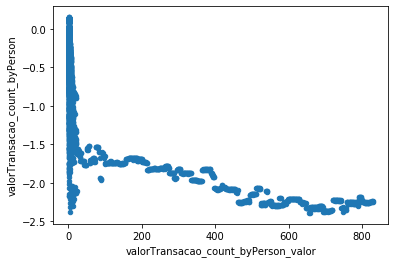

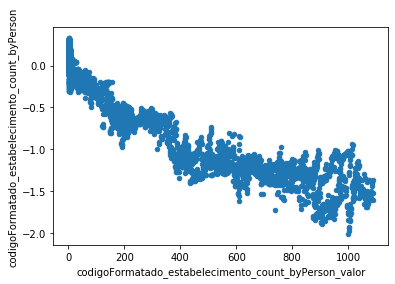

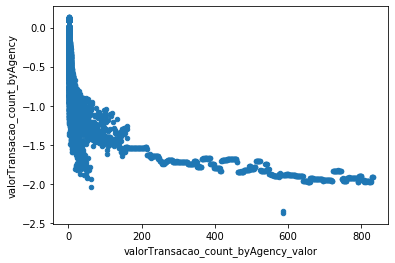

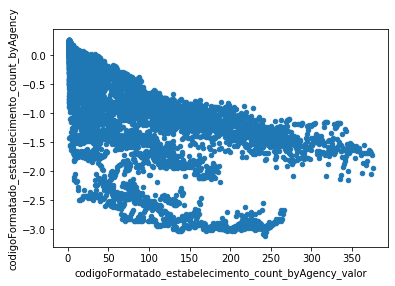

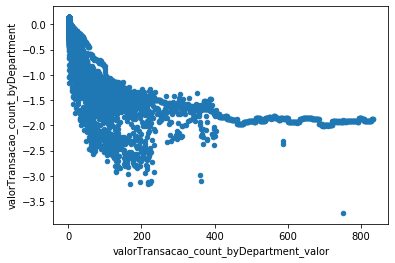

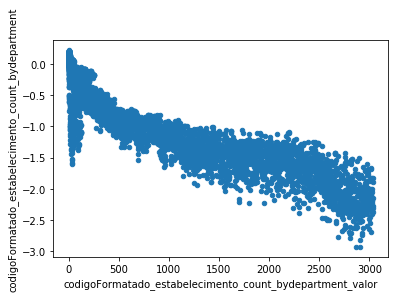

In [43]:
for column in df.columns:
    if column in df_validacao.columns and column+'_valor' in df_validacao.columns:
        df_validacao.plot.scatter(x=column+'_valor', y=column)